In [1]:
import s3fs
import xarray as xr 
import numpy as np 
import cmocean
import matplotlib.pyplot as plt 

In [4]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)

dzz = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)

In [5]:
dv

<xarray.Dataset>
Dimensions:        (depth: 75, t: 1, time_counter: 73, x: 1200, y: 900)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: t, x, y
Data variables:
    mbathy         (t, y, x) int16 dask.array<chunksize=(1, 900, 1200), meta=np.ndarray>
    vel            (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vomecrty       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vozocrtx       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [6]:
u = dv.vozocrtx.mean(dim='time_counter')
v = dv.vomecrty.mean(dim='time_counter')
u.shape

(75, 900, 1200)

In [7]:
# Quiver
x = np.linspace(0, 1200, 1200)
dx = 20 

y = np.linspace(0, 900, 900)
dy = 20

X, Y = np.meshgrid(y, x)

In [24]:
# chooseing a level to look at 
level = 35
depth = dv.depth[level].values
print(depth)

y_grid = np.array(Y.T[::dx,::dy])
print(y_grid.shape)
x_grid = np.array(X.T[::dx,::dy])
u_grid = np.array(u[level,::dx,::dy].values)#endring
print(u_grid.shape)
v_grid = np.array(v[level,::dx,::dy].values)

vel = (u**2 + v**2)**0.5
vel_grid = np.array(vel[level,::dx,::dy].values)

333.86282
(45, 60)
(45, 60)


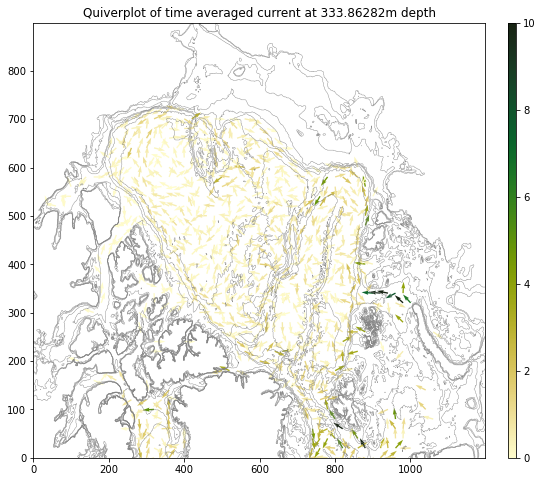

In [25]:
# plotting the quiver
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap_o = plt.get_cmap(cmocean.cm.speed)

ax.contour(dv.mbathy.isel(t=0), colors='grey', levels=8, linewidths=0.4)
norm = plt.Normalize(vmin=0.,vmax=10.,clip=False)
c = ax.quiver(y_grid, 
        x_grid,
        u_grid/vel_grid,
        v_grid/vel_grid,
        vel_grid*100, #*100 to get cm/s as the mooring velcity are in 
        scale = 40,  
        width=0.003,
        #headwidth=2,
        #headlength=1,
        cmap = cmap_o,
             norm=norm) 

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)
         
plt.title(f'Quiverplot of time averaged current at '+ str(depth) + 'm depth')

plt.savefig('quiver_333.pdf', dpi = 300)

In [11]:
# chooseing a level to look at 
level = 0
depth = dv.depth[level].values
print(depth)

y_grid = np.array(Y.T[::dx,::dy])
print(y_grid.shape)
x_grid = np.array(X.T[::dx,::dy])
u_grid = np.array(u[level,::dx,::dy].values)#endring
print(u_grid.shape)
v_grid = np.array(v[level,::dx,::dy].values)

vel = (u**2 + v**2)**0.5
vel_grid = np.array(vel[level,::dx,::dy].values)

0.50576
(45, 60)
(45, 60)


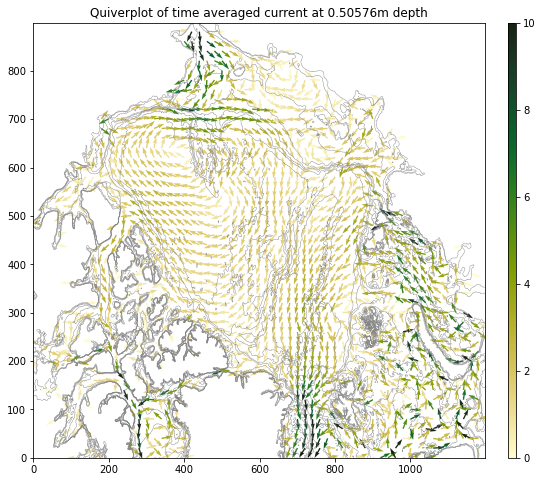

In [21]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap_o = plt.get_cmap(cmocean.cm.speed)

ax.contour(dv.mbathy.isel(t=0), colors='grey', levels=8, linewidths=0.4)
norm = plt.Normalize(vmin=0.,vmax=10.,clip=False)
c = ax.quiver(y_grid, 
        x_grid,
        u_grid/vel_grid,
        v_grid/vel_grid,
        vel_grid*100, #*100 to get cm/s as the mooring velcity are in 
        scale = 40,  
        width=0.003,
        #headwidth=2,
        #headlength=1,
        cmap = cmap_o,
             norm=norm) 

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)
         
plt.title(f'Quiverplot of time averaged current at '+ str(depth) + 'm depth')

plt.savefig('quiver_0.pdf', dpi = 300)